<a href="https://colab.research.google.com/github/AllanKamimura/AI/blob/master/GAN/Pokegan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from IPython import display
from functools import partial
from google_drive_downloader import GoogleDriveDownloader

In [2]:
def plot_results(images, n_cols = None):
    '''visualizes fake images'''
    display.clear_output(wait=False)  
    
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    
    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)
    
    plt.figure(figsize=(n_cols * 1.5, n_rows * 1.5))
    
    for index, image in enumerate(images):
        image = (image + 1) * 127.5
        image = tf.dtypes.cast(image, tf.uint32)
        plt.subplots_adjust(hspace = 0.3)
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image)
        plt.axis("off")

In [3]:
id = "1ZZQVUaBrxOL45rZaV03D5RbUURnfYRtL"
folder = "pokemon"
GoogleDriveDownloader.download_file_from_google_drive(file_id = id,
                                                      dest_path = "/content/" + folder + ".zip",
                                                      unzip = True)

Unzipping...Done.


In [4]:
path_in = "/content/Pokemon"
path_out = "/content/Pokemon_resized"
pokemons = os.listdir(path_in)
try:
    os.mkdir("/content/Pokemon_resized")
except:
    pass

for pokemon in pokemons:
    if ".jpg" in pokemon:
        pass
    else:
        img = tf.keras.preprocessing.image.load_img(path = os.path.join(path_in,pokemon),
                                                    color_mode = "rgba",
                                                    target_size = (64,64))
    
        tf.keras.preprocessing.image.save_img(path = os.path.join(path_out,pokemon),
                                              x = img)
!rm "/content/Pokemon_resized/chesnaught.png"


In [5]:
BATCH_SIZE = 32

# mapping function for preprocessing the image files
def map_images(file):
  '''converts the images to floats and normalizes the pixel values'''
  img = tf.io.decode_png(tf.io.read_file(file))
  x = tf.cast(img, tf.float32) / 127.5 - 1.0
  
  return x

# create training batches
filename_dataset = tf.data.Dataset.list_files("/content/Pokemon_resized/*.png")
image_dataset = filename_dataset.map(map_images).batch(BATCH_SIZE)

In [29]:
# conv_init = tf.keras.initializers.RandomNormal(mean = 0.0, stddev = 0.02)
# norm_init = tf.keras.initializers.RandomNormal(mean = 1.0, stddev = 0.02)
conv_init = "glorot_uniform"
norm_init = "ones"
def Normalization(tipo, norm_init):
    if tipo == "layer":
        return tf.keras.layers.LayerNormalization(gamma_initializer = norm_init)
    elif tipo == "batch":
        return tf.keras.layers.BatchNormalization(gamma_initializer = norm_init)

In [30]:
# You'll pass the random_normal_dimensions to the first dense layer of the generator
random_normal_dimensions = BATCH_SIZE

activation2 = None
activation = "relu"
tipo = "layer"


generator = tf.keras.models.Sequential([
    tf.keras.layers.Dense(units = 128, input_shape = [random_normal_dimensions]),
    tf.keras.layers.Reshape( [1, 1, 128] ),
    Normalization(tipo, norm_init),

    tf.keras.layers.Conv2DTranspose(filters = 512, kernel_size = 4, strides = 1, 
                                    padding = "valid", activation = activation, use_bias = False,
                                    kernel_initializer = conv_init),
    Normalization(tipo, norm_init),
    tf.keras.layers.Activation(activation = activation2),

    tf.keras.layers.Conv2DTranspose(filters = 256, kernel_size = 4, strides = 2, 
                                    padding = "same", activation = activation, use_bias = False,
                                    kernel_initializer = conv_init),
    Normalization(tipo, norm_init),
    tf.keras.layers.Activation(activation = activation2),

    tf.keras.layers.Conv2DTranspose(filters = 128, kernel_size = 4, strides = 2, 
                                    padding = "same", activation = activation, use_bias = False,
                                    kernel_initializer = conv_init),
    Normalization(tipo, norm_init),
    tf.keras.layers.Activation(activation = activation2),

    tf.keras.layers.Conv2DTranspose(filters = 64, kernel_size = 4, strides = 2, 
                                    padding = "same", activation = activation, use_bias = False,
                                    kernel_initializer = conv_init),
    tf.keras.layers.LayerNormalization(gamma_initializer = norm_init),
    Normalization(tipo, norm_init),

    tf.keras.layers.Conv2DTranspose(filters = 4, kernel_size = 4, strides = 2, 
                                    padding = "same", activation = "tanh",
                                    kernel_initializer = conv_init)
], name = "generator")
generator.summary()

Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 128)               2176      
_________________________________________________________________
reshape_3 (Reshape)          (None, 1, 1, 128)         0         
_________________________________________________________________
layer_normalization_29 (Laye (None, 1, 1, 128)         256       
_________________________________________________________________
conv2d_transpose_15 (Conv2DT (None, 4, 4, 512)         1048576   
_________________________________________________________________
layer_normalization_30 (Laye (None, 4, 4, 512)         1024      
_________________________________________________________________
activation_9 (Activation)    (None, 4, 4, 512)         0         
_________________________________________________________________
conv2d_transpose_16 (Conv2DT (None, 8, 8, 256)         20

In [31]:
tipo = "layer"

discriminator = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters = 64, kernel_size = 4, strides = 2, padding = "same", 
                           activation = tf.keras.layers.LeakyReLU(alpha = 0.2), 
                           input_shape = [64,64,4]),
    Normalization(tipo, norm_init),
    tf.keras.layers.Conv2D(filters = 128, kernel_size = 4, strides = 2, padding = "same", 
                           activation = tf.keras.layers.LeakyReLU(alpha = 0.2), use_bias = False),
    Normalization(tipo, norm_init),
    tf.keras.layers.Conv2D(filters = 256, kernel_size = 4, strides = 2, padding = "same", 
                           activation = tf.keras.layers.LeakyReLU(alpha = 0.2), use_bias = False),
    Normalization(tipo, norm_init),
    tf.keras.layers.Conv2D(filters = 512, kernel_size = 4, strides = 2, padding = "same", 
                           activation = tf.keras.layers.LeakyReLU(alpha = 0.2)),
    Normalization(tipo, norm_init),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units = 1, activation = "sigmoid")
   
], name = "discriminator")
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 32, 32, 64)        4160      
_________________________________________________________________
layer_normalization_35 (Laye (None, 32, 32, 64)        128       
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 16, 16, 128)       131072    
_________________________________________________________________
layer_normalization_36 (Laye (None, 16, 16, 128)       256       
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 8, 8, 256)         524288    
_________________________________________________________________
layer_normalization_37 (Laye (None, 8, 8, 256)         512       
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 4, 4, 512)       

In [32]:
discriminator.compile(loss = "binary_crossentropy", optimizer = tf.keras.optimizers.Adam(lr = 0.0002, beta_1 = 0.5))
discriminator.trainable = False

gan = tf.keras.models.Sequential([generator, discriminator])
gan.compile(loss = "binary_crossentropy", optimizer = tf.keras.optimizers.Adam(lr = 0.0002, beta_1 = 0.5))

In [16]:
def train_gan(gan, dataset, random_normal_dimensions, n_epochs=50):
    """ Defines the two-phase training loop of the GAN
    Args:
      gan -- the GAN model which has the generator and discriminator
      dataset -- the training set of real images
      random_normal_dimensions -- dimensionality of the input to the generator
      n_epochs -- number of epochs
    """

    # get the two sub networks from the GAN model
    generator, discriminator = gan.layers
    
    for epoch in range(n_epochs):
        print("Epoch {}/{}".format(epoch + 1, n_epochs))       
        for real_images in dataset:
            
            # infer batch size from the current batch of real images
            real_BATCH_SIZE = real_images.shape[0]
            
            # Train the discriminator - PHASE 1
            # Create the noise
            noise = tf.random.normal([real_BATCH_SIZE, random_normal_dimensions])
            
            # Use the noise to generate fake images
            fake_images = generator(noise)
            
            # Create a list by concatenating the fake images with the real ones
            mixed_images = tf.concat([fake_images, real_images], axis = 0)
            
            # Create the labels for the discriminator
            # 0 for the fake images
            # 1 for the real images
            discriminator_labels = tf.constant([[0.]] * real_BATCH_SIZE + [[1.]] * real_BATCH_SIZE)
            
            # Ensure that the discriminator is trainable
            discriminator.trainable = True
            
            # Use train_on_batch to train the discriminator with the mixed images and the discriminator labels
            discriminator.train_on_batch(mixed_images, discriminator_labels)
            
            # Train the generator - PHASE 2
            # create a batch of noise input to feed to the GAN
            noise = tf.random.normal([real_BATCH_SIZE, random_normal_dimensions])
            
            # label all generated images to be "real"
            generator_labels = tf.constant([[1.]] * real_BATCH_SIZE)
            
            # Freeze the discriminator
            discriminator.trainable = False

            # Train the GAN on the noise with the labels all set to be true
            gan.train_on_batch(noise, generator_labels)
            
        plot_results(fake_images, 4)                     
        plt.show()
    return fake_images

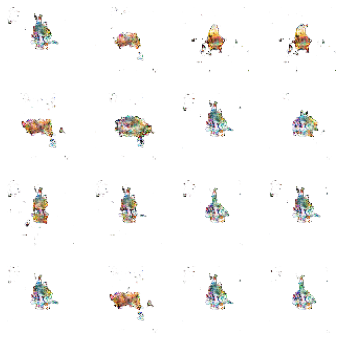

Epoch 12/100


KeyboardInterrupt: ignored

In [45]:
# you can adjust the number of epochs
EPOCHS = 100
# run the training loop and collect images
fake_images = train_gan(gan, image_dataset, random_normal_dimensions, EPOCHS)

In [41]:
f.random.normal([16, random_normal_dimensions])

<tf.Tensor: shape=(16, 16), dtype=float32, numpy=
array([[ 2.19470978e-01, -1.22979319e+00,  1.71270776e+00,
        -1.78898692e-01,  1.12133360e+00, -6.18893266e-01,
         4.73410666e-01,  4.88675326e-01,  2.39360571e+00,
        -2.66679469e-02, -4.08762842e-01, -1.17096341e+00,
        -1.94828749e+00,  2.00030908e-01, -1.81965363e+00,
        -3.21397930e-01],
       [ 5.09361029e-01, -5.30509651e-01, -1.58465004e+00,
         3.80711943e-01, -8.81190181e-01,  6.28928363e-01,
         1.95679367e-01,  1.03385903e-01, -1.04473746e+00,
         3.32309753e-01,  5.92688471e-02, -1.06680226e+00,
         5.37960827e-01, -9.57185775e-02,  1.22025979e+00,
        -6.15801811e-01],
       [ 2.77238309e-01,  1.46261847e+00,  1.20419002e+00,
        -1.39356375e+00, -4.85745966e-01,  1.06004584e+00,
         1.15582418e+00, -8.97663012e-02, -3.89840364e-01,
         8.80238235e-01,  1.96804374e-01,  1.81896150e-01,
         1.79731035e+00, -7.01057017e-02, -8.96206260e-01,
         1.42

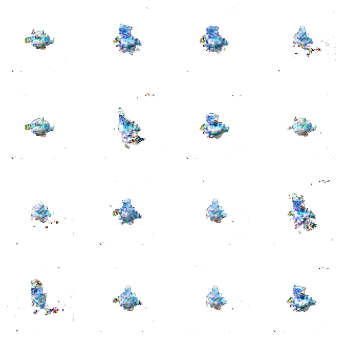

In [44]:
images = generator.predict(tf.random.normal([16, random_normal_dimensions]))
plot_results(images, 4)

In [21]:
def gradient_penalty(f, real, fake):
    def _gradient_penalty(f, real, fake=None):
        def _interpolate(a, b=None):
            if b is None:   # interpolation in DRAGAN
                beta = tf.random.uniform(shape=tf.shape(a), minval=0., maxval=1.)
                b = a + 0.5 * tf.math.reduce_std(a) * beta
            shape = [tf.shape(a)[0]] + [1] * (a.shape.ndims - 1)
            alpha = tf.random.uniform(shape=shape, minval=0., maxval=1.)
            inter = a + alpha * (b - a)
            inter.set_shape(a.shape)
            return inter

        x = _interpolate(real, fake)
        with tf.GradientTape() as t:
            t.watch(x)
            pred = f(x)
        grad = t.gradient(pred, x)
        norm = tf.norm(tf.reshape(grad, [tf.shape(grad)[0], -1]), axis=1)
        gp = tf.reduce_mean((norm - 1.)**2)

        return gp
    gp = _gradient_penalty(f, real, fake)
    return gp

def train_on_batch(real_img):
    '''trains the GAN on a given batch'''

    # PHASE ONE - train the discriminator
    with tf.GradientTape() as d_tape:

        # create noise input
        z = tf.random.normal([16, random_normal_dimensions])

        # generate fake images
        fake_img = generator(z)

        # feed the fake images to the discriminator
        fake_out = discriminator(fake_img)

        # feed the real images to the discriminator
        real_out = discriminator(real_img)

        # use the loss function to measure how well the discriminator
        # labels fake or real images
        d_fake_loss = loss_func(tf.zeros_like(fake_out), fake_out)
        d_real_loss = loss_func(tf.ones_like(real_out), real_out)

        # get the total loss
        d_loss = (d_fake_loss + d_real_loss) 
        d_loss = tf.reduce_sum(d_loss) / (BATCH_SIZE * 2)

        # Gradient Penalty (ignore if you set mode to `none`)
        gp = gradient_penalty(partial(discriminator, training=True), real_img, fake_img)
        gp = gp  / (BATCH_SIZE * 2)
        d_loss = d_loss + gp * gradient_penalty_weight

    # get the gradients
    gradients = d_tape.gradient(d_loss, discriminator.trainable_variables)
    
    # update the weights of the discriminator
    param_D.apply_gradients(zip(gradients, discriminator.trainable_variables))
    

    # PHASE TWO - train the generator
    with tf.GradientTape() as g_tape:
        # create noise input
        z = tf.random.normal([16, random_normal_dimensions])
        
        # generate fake images
        fake_img = generator(z)

        # feed fake images to the discriminator
        fake_out = discriminator(fake_img)
        
        # use loss function to measure how well the generator
        # is able to trick the discriminator (i.e. discriminator should output 1's)
        g_loss = loss_func(tf.ones_like(fake_out), fake_out)
        g_loss = tf.reduce_sum(g_loss) / (BATCH_SIZE * 2)
    
    # get the gradients
    gradients = g_tape.gradient(g_loss, generator.trainable_variables)

    # update the weights of the generator
    param_G.apply_gradients(zip(gradients, generator.trainable_variables))
    
    # return the losses and fake images for monitoring
    return d_loss, g_loss, fake_img 

In [22]:
def gan_train(gan, dataset, random_normal_dimensions, n_epochs=50):
    noise = tf.random.normal([16, random_normal_dimensions])
    for epoch in range(n_epochs):
        print("Epoch {}/{}".format(epoch + 1, n_epochs))
        for real_images in dataset:
            d_loss, g_loss, fake_images = train_on_batch(real_images)
        plot_results(fake_images, 4)                     
        plt.show()
        print(d_loss, g_loss) 
    return fake_images

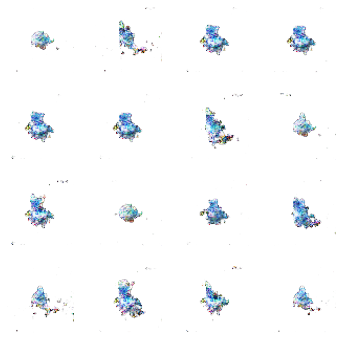

tf.Tensor(0.3582803, shape=(), dtype=float32) tf.Tensor(2.7322512e-05, shape=(), dtype=float32)
Epoch 9/50


KeyboardInterrupt: ignored

In [43]:
gradient_penalty_weight = 5
BATCH_SIZE = 16
image_dataset = filename_dataset.map(map_images).batch(BATCH_SIZE)
loss_func = tf.keras.losses.BinaryCrossentropy(from_logits = True)
optimizer = tf.keras.optimizers.Adam(lr = 0.0002, beta_1 = 0.5)
param_D = optimizer
param_G = optimizer
fake_images = gan_train(gan, image_dataset, random_normal_dimensions)